# Lab Assignment 2 Stochastic Simulation

### Marleen Rijksen (10465030)

In [26]:
# necessary imports
import simpy
import numpy as np
import time
import random
%pylab inline
pylab.rcParams['figure.figsize'] = [10, 6]

Populating the interactive namespace from numpy and matplotlib


/home/marleen/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'std', 'mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Simulation of Queue
The code to simulate the queue is based on a SimPy example. The code of this example can be found on https://simpy.readthedocs.io/en/latest/examples/carwash.html

In [208]:
"""
Maze

Scenario:
  A maze has a limited capacity regarding to the number of people
  in the maze at a certain time. The time people spend in the maze 
  is some random value.
  
  People arrive at the maze at a random time. If the maze is not full
  yet then a person can go into the maze and try to find the exit. If
  the maze is full the person will wait until someone exits the maze.

"""
global guest_information

class Maze(object):
    """A maze has a limited capacity (``CAPACITY``) which is the maximum
    number of persons thay can be in the maze at the same time. 
    
    Persons have to request the available spots in the maze. When they
    got one, they can start walking through the maze and hope they will
    get out at some time (which takes ``EXITTIME`` hours)

    """
    
    # create environment and resource
    def __init__(self, env, capacity):
        self.env = env
        self.machine = simpy.PriorityResource(env, capacity)

    def walk(self, person, exittime):
        """The walking processes. It takes a ``guest`` processes and tries
        to clean it."""
        
        yield self.env.timeout(exittime)
        #print("%s gives the maze a score of %d%%." %
         #     (person, random.randint(1, 99)))

        
def guest(env, name, mz, service_rate, priority, mdn, mltn):
    """The person process (each person has a ``name``) arrives at the maze
    (``mz``) and requests a spot in the maze

    It then starts walking, hopes to finish soon and
    leaves to never come back (depending on the score) ...

    """
    
    # save arrival time of guest
    #print('%s arrives at the maze at %.2f.' % (name, env.now))
    arrival_time = env.now

    # check for distribution and compute time of service
    # deterministic distribution
    if mdn == True:
        time_of_service = 1 / service_rate
        
    # longtail (exponential) distribution
    elif mltn == True:
        rn = np.random.uniform()
        if rn < 0.75:
            time_of_service = abs(np.random.exponential(1))
        else:
            time_of_service = abs(np.random.exponential(5))
    
    # exponential distribution
    else:
        time_of_service = np.random.exponential(1 / service_rate)
            
    # check for priority
    if priority == True:
        prio = time_of_service
    else:
        prio = 1
    
    # request maze
    with mz.machine.request(priority=prio) as request:
        yield request
        
        # save service time of guest
        #print('%s enters the maze at %.2f.' % (name, env.now))
        service_time = env.now        
        yield env.process(mz.walk(name, time_of_service))
        
        # save the time of exit of guest
        #print('%s leaves the maze at %.2f.' % (name, env.now))
        exit_time = env.now  
        
        # store all data of guest in list
        guest_information.append([arrival_time, service_time, exit_time])

def setup(env, capacity, arr_rate, service_rate, num_guests, priority, mdn, mltn):
    """Create a maze, a number of initial persons and keep creating persons
    approx. every ``t_inter`` minutes."""
    
    # Create the maze
    maze = Maze(env, capacity)

    # create initial guest at t=0
    i = 1
    env.process(guest(env, 'Guest %d' % i, maze, service_rate, priority, mdn, mltn))

    # Create more guests while the simulation is running
    for j in range(num_guests - 1):
        yield env.timeout(np.random.exponential(1 / arr_rate))
        i += 1
        env.process(guest(env, 'Guest %d' % i, maze, service_rate, priority, mdn, mltn))

In [8]:
#import matplotlib.pyplot as plt
#row = np.array(row)
#times = row[:, 0]
#queue = row[:, 1]
#print(len(queue))
#plt.plot(times, queue)
#plt.show()
    

In [9]:
# we have our data stored in guest_information
# guest_information[0] = arrival_time
# guest_information[1] = service_time
# guest_information[2] = exit_time

In [209]:
# function which computes mean and std of waiting time for specified constants
def simulate_queue(rho, n, mu, num_guests, num_sims, priority, mdn, mltn, warmup_number):
    labda = rho * n * mu           # arrival rate
    queue = 0                      # length of queue
    mean_waiting_list = []         # list with all means of waiting time
    global guest_information
    
    # iterate over simulations 
    for i in range(num_sims):
        guest_information = []
        row = []

        # create an environment and start the setup process
        env = simpy.Environment()
        env.process(setup(env, n, labda, mu, num_guests, priority, mdn, mltn))

        # execute simulation
        env.run()
        
        # compute mean every simulation
        mean = np.mean(np.array(guest_information)[warmup_number:, 1] - \
                       np.array(guest_information)[warmup_number:, 0])
        mean_waiting_list.append(mean)
        
    # return final mean and std
    return np.mean(mean_waiting_list), np.std(mean_waiting_list)

TypeError: simulate_queue() missing 1 required positional argument: 'warmup_number'

## Investigate Warm-Up Period
For 1 simulation we want to know how the waiting times are during simulation.

In [211]:
# function which plots the waiting time averages of the first n guests 
# for multiple simulations
def warm_up(rho, n, mu, num_guests, num_sims, priority, mdn, mltn):
    global guest_information
    waiting_times_sims = []
    
    # do multiple simulations
    for i in range(num_sims):
        guest_information = []

        # create an environment and start the setup process
        env = simpy.Environment()
        env.process(setup(env, n, labda, mu, num_guests, priority, mdn, mltn))

        # execute simulation
        env.run()

        # compute mean every simulation
        waiting_times = np.array(guest_information)[:, 1] - np.array(guest_information)[:,0]

        # generate list of mean waiting times during simulation
        mean_waiting_times = []
        for i in range(len(waiting_times)):
            mean_waiting_times.append(np.mean(waiting_times[0:i + 1]))

        # add mean_waiting_times to array of all sims
        waiting_times_sims.append(mean_waiting_times)

    # compute mean of mean of waiting times for simulations
    waiting_times_sims = np.array(waiting_times_sims)
    means_sims = np.mean(waiting_times_sims.T, 1)
    
    # plot mean of mean of waiting times for first n guests
    std = np.std(waiting_times_sims.T)
    plt.plot(means_sims, c='r')
    plt.xlabel('Guest Number')
    plt.ylabel('Mean Waiting Time')        
        
    # determine title depending on distribution
    plt.title('Average Waiting Time First n Guests Queue (Longtail Distribution)')
    
    fill_between(range(num_guests), means_sims-std, means_sims+std,
        alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

## Investigate the effect of system load on average waiting time and standard deviation for M/M/n queue

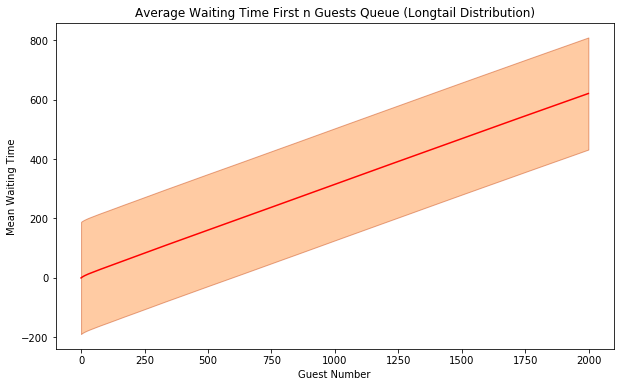

In [212]:
# first investigate the warm up period
# variables and constants 
rho = 0.9                      # system load
n = 1                          # maximal number of persons in maze
mu = 0.25 * (1 / 5) + 0.75     # service rate
num_guests = 2000              # number of guests we want to simulate
num_sims = 300
row = []
priority = False 
mdn = False
mltn = True
labda = rho * n * mu           # arrival rate
warm_up(rho, n, mu, num_guests, num_sims, priority, mdn, mltn)

In [148]:
# variables and constants 
n = 1                         # maximal number of persons in maze
mu = 1                         # service rate
num_guests = 1000              # number of guests we want to simulate
num_sims = 200                # number of simulations
row = []
priority= False
mdn = False
mltn = False
rho_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# simulate for one server
mean_list_1 = []
std_list_1 = []

# simulate queue for different rhos
for rho in rho_list:
    mean, std = simulate_queue(rho, n, mu, num_guests, num_sims, priority, mdn, mltn, 500)
    mean_list_1.append(mean)
    std_list_1.append(std)
    
# simulate for two servers
mean_list_2 = []
std_list_2 = []
n = 2

# simulate queue for different rhos
for rho in rho_list:
    mean, std = simulate_queue(rho, n, mu, num_guests, num_sims, priority, mdn, mltn, 500)
    mean_list_2.append(mean)
    std_list_2.append(std)
    
# simulate for five servers
mean_list_4 = []
std_list_4 = []
n = 4

# simulate queue for different rhos
for rho in rho_list:
    mean, std = simulate_queue(rho, n, mu, num_guests, num_sims, priority, mdn, mltn, 500)
    mean_list_4.append(mean)
    std_list_4.append(std)

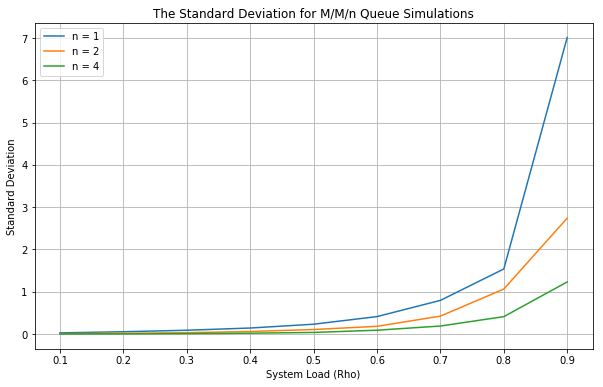

In [152]:
# plot std vs rho
plt.plot(rho_list, std_list_1, label='n = 1')
plt.plot(rho_list, std_list_2, label='n = 2')
plt.plot(rho_list, std_list_4, label='n = 4')
plt.title('The Standard Deviation for M/M/n Queue Simulations')
plt.xlabel('System Load (Rho)')
plt.ylabel('Standard Deviation')
plt.grid()
plt.legend()
plt.show()

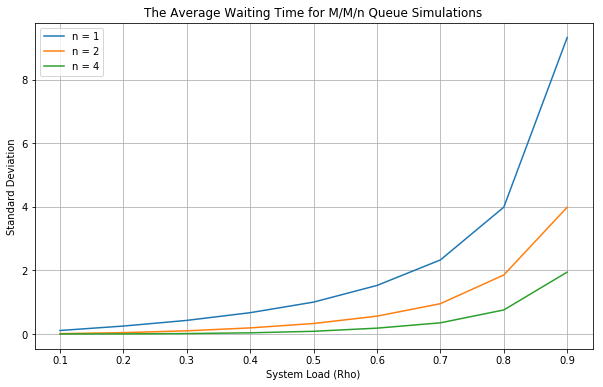

In [153]:
# plot mean vs rho
plt.plot(rho_list, mean_list_1, label='n = 1')
plt.plot(rho_list, mean_list_2, label='n = 2')
plt.plot(rho_list, mean_list_4, label='n = 4')
plt.title('The Average Waiting Time for M/M/n Queue Simulations')
plt.xlabel('System Load (Rho)')
plt.ylabel('Standard Deviation')
plt.legend()
plt.grid()
plt.show()

### Result M/M/1 Queue

In [173]:
# variables and constants 
n = 1                         # maximal number of persons in maze
mu = 1                         # service rate
num_guests = 1000              # number of guests we want to simulate
num_sims = 3000               # number of simulations
row = []
priority= False
mdn = False
mltn = False
rho = 0.9

mean, std = simulate_queue(rho, n, mu, num_guests, num_sims, priority, mdn, mltn, 500)
conf_int = 1.96 * std / np.sqrt(num_sims)

In [175]:
print(mean, std, conf_int)

9.03782502945 6.52503411183 0.233495346941


### Results M/M/2 Queue

In [177]:
# variables and constants 
n = 2                         # maximal number of persons in maze
mu = 1                         # service rate
num_guests = 1000              # number of guests we want to simulate
num_sims = 3000               # number of simulations
row = []
priority= False
mdn = False
mltn = False
rho = 0.9

mean, std = simulate_queue(rho, n, mu, num_guests, num_sims, priority, mdn, mltn, 500)
conf_int = 1.96 * std / np.sqrt(num_sims)

In [178]:
print(mean, std, conf_int)

4.25960256122 3.21504903492 0.115049052154


### Results M/M/4 Queue

In [179]:
# variables and constants 
n = 4                         # maximal number of persons in maze
mu = 1                         # service rate
num_guests = 1000              # number of guests we want to simulate
num_sims = 3000               # number of simulations
row = []
priority= False
mdn = False
mltn = False
rho = 0.9

mean, std = simulate_queue(rho, n, mu, num_guests, num_sims, priority, mdn, mltn, 500)
conf_int = 1.96 * std / np.sqrt(num_sims)

In [180]:
print(mean, std, conf_int)

1.91408000148 1.5795935333 0.0565250286453


### Results M/M/1 Queue with priority

In [185]:
# variables and constants 
n = 1                         # maximal number of persons in maze
mu = 1                         # service rate
num_guests = 900              # number of guests we want to simulate
num_sims = 3000               # number of simulations
row = []
priority = True
mdn = False
mltn = False
rho = 0.9

mean, std = simulate_queue(rho, n, mu, num_guests, num_sims, priority, mdn, mltn, 400)
conf_int = 1.96 * std / np.sqrt(num_sims)

In [187]:
print(mean, std, conf_int)

3.34535661752 1.6656050702 0.0596029119645


### Results M/D/1 Queue

In [188]:
# variables and constants 
n = 1                         # maximal number of persons in maze
mu = 1                         # service rate
num_guests = 1000              # number of guests we want to simulate
num_sims = 3000               # number of simulations
row = []
priority = False
mdn = True
mltn = False
rho = 0.9

mean, std = simulate_queue(rho, n, mu, num_guests, num_sims, priority, mdn, mltn, 500)
conf_int = 1.96 * std / np.sqrt(num_sims)

In [189]:
print(mean, std, conf_int)

4.39601488058 2.27550221052 0.0814278008365


### Results Queue With Longtail Distribution

In [213]:
# variables and constants 
n = 1                         # maximal number of persons in maze
mu = 0.25 * 1 / 5 + 0.75 * 1      # service rate
num_guests = 750              # number of guests we want to simulate
num_sims = 3000               # number of simulations
row = []
priority = False
mdn = False
mltn = True
rho = 0.9

mean, std = simulate_queue(rho, n, mu, num_guests, num_sims, priority, mdn, mltn, 250)
conf_int = 1.96 * std / np.sqrt(num_sims)

In [203]:
print(mean, std, conf_int)

312.938329449 71.5174202723 8.09295796181
